In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_next_available_dir(root_dir):
    """
    If a directory at 'root_dir' exists, append a number to create a new path.
    For example, if 'RUN' exists, this returns 'RUN_01', and so on.
    """
    if not os.path.exists(root_dir):
        return root_dir

    i = 1
    new_dir = f"{root_dir}_{str(i).zfill(2)}"

    while os.path.exists(new_dir):
        i += 1
        new_dir = f"{root_dir}_{str(i).zfill(2)}"

    return new_dir

In [3]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3
epochs_optimal_lr = 3
patience_teacher = 6
patience_student = 6
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_teacher = [0]
lmda_list_student = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# SPECIFY OUT DIR NAME
# Create directory and file path to save all outputs
directory_name = 'Smaller_Student_Models'
# This will append version to end of directory name and create new directory if already exists
output_dir = get_next_available_dir(directory_name)

os.makedirs(output_dir, exist_ok=True)

In [4]:
# Paths for subdirectories inside output_dir
models_dir = os.path.join(output_dir, 'models')
weights_dir = os.path.join(output_dir, 'weights')

# Create the subdirectories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Initialize EfficientNet B2
efficientnet_b2 = models.efficientnet_b2(pretrained=True)
efficientnet_b2.classifier[1] = nn.Linear(efficientnet_b2.classifier[1].in_features, num_classes)

# Initialize EfficientNet B1
efficientnet_b1 = models.efficientnet_b1(pretrained=True)
efficientnet_b1.classifier[1] = nn.Linear(efficientnet_b1.classifier[1].in_features, num_classes)

# Initialize EfficientNet B0
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, num_classes)

# Initialize MobileNetV2
student_model_mobilenetv2 = models.mobilenet_v2(pretrained=True)
student_model_mobilenetv2.classifier[1] = nn.Linear(student_model_mobilenetv2.classifier[1].in_features, num_classes)

# Initialize ShuffleNet
student_model_shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
num_features = student_model_shufflenet.fc.in_features
student_model_shufflenet.fc = nn.Linear(num_features, num_classes)

# Initialize SqueezeNet
student_model_squeezenet = models.squeezenet1_0(pretrained=True)
student_model_squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
student_model_squeezenet.num_classes = num_classes

class CustomSmallCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomSmallCNN, self).__init__()
        # Convolutional layer (input channels, output channels, kernel size)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Adaptive pooling to make it size-agnostic
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 5 * 5, 120)  # 5*5 is derived from the adaptive pooling size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Apply convolutions, followed by max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Adaptive pooling and flattening
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Custom Ultra Tiny CNN
student_model_custom_small_cnn = CustomSmallCNN(num_classes=num_classes)


In [6]:
# Count parameters
total_params_efficientnet_b2 = count_parameters(efficientnet_b2)
total_params_efficientnet_b1 = count_parameters(efficientnet_b1)
total_params_efficientnet_b0 = count_parameters(efficientnet_b0)
total_params_mobilenetv2 = count_parameters(student_model_mobilenetv2)
total_params_shufflenet = count_parameters(student_model_shufflenet)
total_params_squeezenet = count_parameters(student_model_squeezenet)
total_params_custom_small_cnn = count_parameters(student_model_custom_small_cnn)

print(f"EfficientNet B2 Total Parameters: {total_params_efficientnet_b2}")
print(f"EfficientNet B1 Total Parameters: {total_params_efficientnet_b1}")
print(f"EfficientNet B0 Total Parameters: {total_params_efficientnet_b0}")
print(f"MobileNetV2 Total Parameters: {total_params_mobilenetv2}")
print(f"ShuffleNet Total Parameters: {total_params_shufflenet}")
print(f"SqueezeNet Total Parameters: {total_params_squeezenet}")
print(f"Custom Small CNN Total Parameters: {total_params_custom_small_cnn}")


EfficientNet B2 Total Parameters: 7723538
EfficientNet B1 Total Parameters: 6533680
EfficientNet B0 Total Parameters: 4028044
MobileNetV2 Total Parameters: 2244368
ShuffleNet Total Parameters: 1270004
SqueezeNet Total Parameters: 743632
Custom Small CNN Total Parameters: 112732


In [ ]:
# List of models
student_models = [
    efficientnet_b2, 
    efficientnet_b1, 
    efficientnet_b0, 
    student_model_mobilenetv2, 
    student_model_shufflenet, 
    student_model_squeezenet,
    student_model_custom_small_cnn
]


In [7]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [8]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [9]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [10]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [11]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [12]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [13]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [14]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [15]:
len(train_dataset)

10324

In [16]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


# Start Training Process

In [17]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix

In [18]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [19]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()


In [20]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)

In [21]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)

In [22]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)

In [23]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()

In [24]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [25]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [26]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [27]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [28]:
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity

            # Save the teacher model and its state to the 'output_dir'
            teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
            torch.save(teacher_model.state_dict(), teacher_model_weights_path)
            
            teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_checkpoint{i}.pth')
            torch.save(teacher_model, teacher_model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")

        print(f"Data has been appended to {file_path}")
        
    plot_loss_curve(val_losses)
    print(f"Finished Training Teacher for lambda val of {lmda}")
    return val_disparities



def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizers, optimizera, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)
        if lmda != 0:
            adv.train()
            adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizers.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # Run the adversarial model on concatenated true labels, and predicted labels
            if lmda != 0:
                optimizera.zero_grad()
                studentached = student_outputs.detach()
                with torch.no_grad():
                    adversary_output = adv(studentached)
                adversary_loss = adv_criterion(adversary_output, targets)
                
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()

            optimizers.step()
            if lmda != 0:
                optimizera.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        student_epoch_losses.append(epoch_loss)

        student.eval()
        adv.eval()
        adv.to(device)
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)
                if lmda != 0:
                    val_studentached = val_student_outputs.detach()   

                    val_adversary_output = adv(val_studentached)
                    val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                    
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                    
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            state_dict_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student.state_dict(), state_dict_path)
            model_path = os.path.join(output_dir, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        print(f"Data has been appended to {file_path}")

    plot_loss_curve(val_losses)
    print(f'Finished Training Student for lambda value of {lmda}')
    return val_disparities


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 1/1*****
*****Train Loss:  1.555877 Val Loss:  1.181927*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.10165457036611443*****

Class Team_Sports: Recall Difference = 0.07268282094343714
Class Celebration: Recall Difference = -0.010544554455445554
Class Parade: Recall Difference = 0.02367424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.03436426116838498
Class Individual_Sports: Recall Difference = -0.12262016229712869
Class Surgeons: Recall Difference = 0.01552106430155209
Class Spa: Recall Difference = -0.16666666666666663
Class Law_Enforcement: Recall Difference = 0.20352112676056333
Class Business: Recall Difference = 0.008623442989460273
Class Dresses: Recall Difference = -0.41516966067864275
Class Water_Activities: Recall Difference = 0.044602938045561036
Class Picnic: Recall Difference = -0.2875816993464052
Class Rescue: Recall Difference = 0.01443850267379676
Class Cheering: Recall Difference = 0.046235679214402636
Class Performance

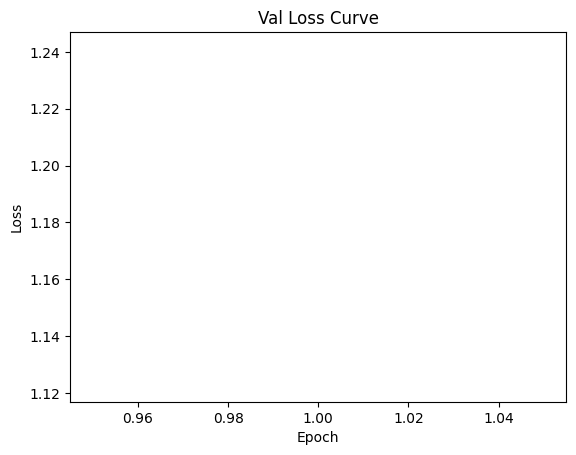

Finished Training Teacher for lambda val of 0
Teacher weights and architecture saved and exported for lambda: 0


In [29]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state to the 'output_dir'
    teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model.state_dict(), teacher_model_weights_path)
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, teacher_model_path)
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 1/1*****
*****Train Loss:  0.387573 Val Loss:  0.352433*****
*****Validation Accuracy: 22.60%*****
*****Total Avg Disparity: 0.05552857940179361*****

Class Team_Sports: Recall Difference = -0.029520969713587086
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.10321969696969699
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.07361891385767788
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.01575473706621247
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_11/student_validation_0.txt


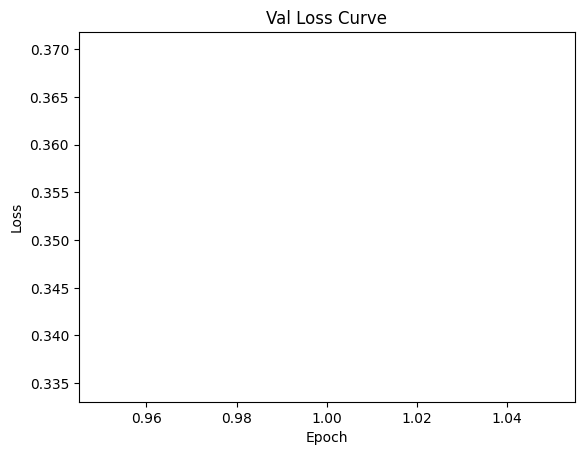

Finished Training Student for lambda value of 0
Student model CustomSmallCNN saved for lambda 0 to Smaller_Student_Models_11/models/CustomSmallCNN_lambda0_20231206_093934.pth
Weights saved for lambda 0 to Smaller_Student_Models_11/weights/CustomSmallCNN_weights_lambda0_20231206_093934.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.64it/s]


*****Epoch 1/1*****
*****Train Loss:  0.201419 Val Loss:  0.145546*****
*****Validation Accuracy: 63.26%*****
*****Total Avg Disparity: 0.17714795224019117*****

Class Team_Sports: Recall Difference = 0.09393243536575613
Class Celebration: Recall Difference = 0.1093564356435644
Class Parade: Recall Difference = 0.008522727272727071
Class Waiter_Or_Waitress: Recall Difference = 0.014891179839633284
Class Individual_Sports: Recall Difference = -0.21598002496878888
Class Surgeons: Recall Difference = -0.08130081300812997
Class Spa: Recall Difference = -0.2499999999999999
Class Law_Enforcement: Recall Difference = 0.21314553990610352
Class Business: Recall Difference = -0.06685829873309906
Class Dresses: Recall Difference = -0.8742514970059881
Class Water_Activities: Recall Difference = -0.021715988929103647
Class Picnic: Recall Difference = -0.40522875816993453
Class Rescue: Recall Difference = 0.1147058823529411
Class Cheering: Recall Difference = 0.05094108019639934
Class Performance_An

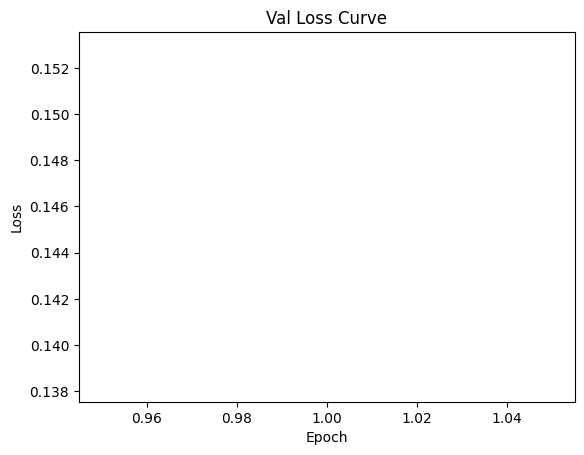

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_11/models/EfficientNet_lambda0_20231206_094049.pth
Weights saved for lambda 0 to Smaller_Student_Models_11/weights/EfficientNet_weights_lambda0_20231206_094049.pth


 35%|███████████████████████████████████████▊                                                                         | 57/162 [00:38<01:10,  1.49it/s]


KeyboardInterrupt: 

In [30]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # Load the teacher model with lambda 0
    teacher_model_path = os.path.join(output_dir, 'teacher_model_ckd_wider_lambda0.pth')
    teacher_model = torch.load(teacher_model_path)
    teacher_model_weights_path = os.path.join(output_dir, 'teacher_model_weights_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load(teacher_model_weights_path))
    teacher_model = teacher_model.to(device)
        
    for student_model in student_models:
        model_name = type(student_model).__name__
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name}_lambda{i}_{timestamp}.pth"
        weights_filename = f"{model_name}_weights_lambda{i}_{timestamp}.pth"

        # Reset the optimizer for the student model for each lambda
        student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
        
        # Initialize the adversary
        adv = Adversary()
        student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
        
        # Pretrain student and adversary if i != 0
        if i != 0:
            pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
            pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
        
        # Train the student model with knowledge distillation and disparity reduction
        student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, 
                                                                                   adv_criterion, student_optimizer, student_optimizer_adv, device, alpha, 
                                                                                   temperature, epochs, lmda=i, patience=patience_student)
    
        # Save the trained student model and its weights
        model_save_path = os.path.join(models_dir, model_filename)
        weights_save_path = os.path.join(weights_dir, weights_filename)
    
        torch.save(student_model, model_save_path)
        torch.save(student_model.state_dict(), weights_save_path)
    
        print(f"Student model {model_name} saved for lambda {i} to {model_save_path}")
        print(f"Weights saved for lambda {i} to {weights_save_path}")
    
        # Update the dictionary with the student results
        if i not in lambda_results:
            lambda_results[i] = {model_name: {'student_mean_abs_val_disparity': student_mean_abs_val_disparity}}
        else:
            if model_name not in lambda_results[i]:
                lambda_results[i][model_name] = {'student_mean_abs_val_disparity': student_mean_abs_val_disparity}
            else:
                lambda_results[i][model_name].update({'student_mean_abs_val_disparity': student_mean_abs_val_disparity})


In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [ ]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting only with markers and no lines
plt.scatter(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.scatter(student_lambdas, student_acc, label='Student Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# Extracting lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.scatter(student_lambdas, student_prec, label='Student Precision', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# Extracting lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.scatter(student_lambdas, student_rec, label='Student Recall', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# Extracting lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.scatter(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# Extracting lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.scatter(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Extracting lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.scatter(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            # Take the last value if there are multiple
            teacher_disparity = teacher_disparity[-1] if isinstance(teacher_disparity, list) else teacher_disparity
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            # Take the last value if there are multiple
            student_disparity = student_disparity[-1] if isinstance(student_disparity, list) else student_disparity
            student_disparities.append((key, student_disparity))

# Extracting lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Creating a scatter plot
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.scatter(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.scatter(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_class_filter(info_list, display_class, new_label_mapping, rows=10, cols=5):
    # Filter the info list based on the specified class, student correct and teacher incorrect predictions
    filtered_info = [info for info in info_list if info['actual_class'] == display_class and 
                     info['student_pred_class'] == display_class and 
                     info['teacher_pred_class'] != display_class]

    # Calculate the number of images to display based on the length of the filtered list
    num_images = len(filtered_info)
    total_plots = min(rows * cols, num_images)  # Ensure we don't exceed the number of filtered images

    # Determine the number of rows needed based on the number of images
    rows = (num_images + cols - 1) // cols

    # Create a figure with the adjusted number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(total_plots):
        data = filtered_info[i]
        image = data['image']
        actual_class = new_label_mapping[data['actual_class']]  # Get class name from the mapping
        teacher_pred_class = new_label_mapping[data['teacher_pred_class']]  # Get class name from the mapping
        student_pred_class = new_label_mapping[data['student_pred_class']]  # Get class name from the mapping
        actual_attribute = round(data['actual_attribute'], 3)
    
        # Normalize the image for display
        image_display = image.cpu().numpy().transpose(1, 2, 0)
        image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
        # Set the title with the class and attribute information
        title = f'Attr: {actual_attribute}\nTrue: {actual_class}\nTeacher: {teacher_pred_class}\nStudent: {student_pred_class}'
    
        axes[i].imshow(image_display)
        axes[i].set_title(title, fontsize=12, pad=4)
        axes[i].axis('off')

    # Turn off any unused axes
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()


In [ ]:
teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda0.pth')
teacher_model = torch.load(teacher_model_path)
student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda4.pth')
student_model = torch.load(student_model_path)

# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

for i in range(num_classes):
    # Display images with details
    print('#'*60)
    print(f'CLASS {i}: {new_label_mapping[i]}')
    print('#'*60)
    plot_images_with_class_filter(detailed_info, display_class=i, new_label_mapping=new_label_mapping, rows=10, cols=5)


In [ ]:
def get_disparities_accuracies_student(lmda, dataloader):
    model_path = os.path.join(output_dir,f'student_model_ckd_wider_lambda{lmda}.pth') 
    model = torch.load(model_path)
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
for i in lmda_list_student:
    get_disparities_accuracies_student(i, testloader)

In [ ]:
def get_disparities_accuracies_teacher(lmda, dataloader):
    model_path = os.path.join(output_dir,f'teacher_model_ckd_wider_lambda{lmda}.pth') 
    model = torch.load(model_path)
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
get_disparities_accuracies_teacher(0, testloader)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Data for plotting
labels = ['Teacher (λ=0)', 'Student (λ=0)', 'Student (λ=8)']
waiter_or_waitress_values = [-0.0925, -0.1082, 0.0046]
individual_sports_values = [-0.1208, -0.1345, -0.0794]

# Number of bars
n_bars = len(labels)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of the bars

# Positions of the bars on the x-axis
r1 = range(n_bars)
r2 = [x + bar_width for x in r1]

# Creating the bars with improved colors
plt.bar(r1, waiter_or_waitress_values, color=colors[0], width=bar_width, edgecolor='grey', label='Waiter Or Waitress')
plt.bar(r2, individual_sports_values, color=colors[1], width=bar_width, edgecolor='grey', label='Individual Sports')

# Adding data labels
for i in range(n_bars):
    plt.text(r1[i] - bar_width/8, waiter_or_waitress_values[i], f'{waiter_or_waitress_values[i]:.4f}', ha='center', va='bottom')
    plt.text(r2[i] - bar_width/8, individual_sports_values[i], f'{individual_sports_values[i]:.4f}', ha='center', va='bottom')

# General layout
plt.ylabel('Disparity Values')
plt.title('Disparity')
plt.xticks([r + bar_width/2 for r in range(n_bars)], labels)
plt.legend()

# Show plot
plt.show()
